In [1]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import sys
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import datetime
import pickle
sys.path.append('../scripts')
import sowing_date_functions as sfuncs
import metric_evaluation_functions as mefuncs

In [2]:
# --- 1. Load Data ---
ts_data_path = '../output/raw_timeseries'
#Checking all the files
os.listdir(ts_data_path)

### setting directory
output_dir= '../output/'
output_dir_smoothed = '../output/smoothed_timeseries/'
output_dir_raw = '../output/raw_timeseries/'
plot_output_dir = '../output/plots/'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_raw, exist_ok=True)
os.makedirs(output_dir_smoothed, exist_ok=True)
os.makedirs(plot_output_dir, exist_ok=True)

In [3]:
## Data preparation - Convert to right date format; - Survey; - Remote sensing data
#choose the year to be considered and for consequence choose the right columns
year = 2022
##_______________________________________________________
#Setup a Day of Period - in this way all the date it will be in days aft a initial date - DAY of Period (maybe not the best name).
#This is to avoid confusion when a season start in a year X and end in a season X+1
init_date = pd.to_datetime(f"{year}-1-1", format='%Y-%m-%d')
delta_days_sowing_sos = 10
delta_weeks_sowing_sos = round(delta_days_sowing_sos / 7)

VI_COL = "NDVI"

delta_days_sowing_sos = 10 # in days

### start and end date to consider in the sow date extraction (phenology). Trying to grab the max NDVI too to the sow date calculation. The sow data should not be less that the month here
season_info = {
    "start": datetime.date(year, 11, 1), 
    "end": datetime.date(year + 1, 5, 1),
    "end_sowing":datetime.date(year,12,31)
}


### start and end date to apply smooth function.
start_date = datetime.date(year,7,1)
end_date = datetime.date(year+1,10,31)

In [4]:
print("Initial Date:", init_date)
print("Delta Days Sowing Start of Season (SOS):", delta_days_sowing_sos)
print("Delta Weeks Sowing SOS (rounded):", delta_weeks_sowing_sos)

Initial Date: 2022-01-01 00:00:00
Delta Days Sowing Start of Season (SOS): 10
Delta Weeks Sowing SOS (rounded): 1


In [5]:
#Read the raw data (extracted in the previous step)
reducer = "mean"
sensors =["HLS", "sentinel-2", "MODIS"]#["sentinel-2"]# ["HLS", "sentinel-2", "MODIS"]

data_frames = {}
#get the files with the patter for the sensor and metric
for sensor in sensors:
    files = glob.glob(os.path.join(ts_data_path ,f"*_metrics_{sensor}_data_*_{reducer}.csv"))
    # if there are no file or more than 1 file, we need double check what is wrong.
    if len(files) == 1:
        print(f"Sensor: {sensor}. Reading file {files[0]}")
        data_frames[sensor] = pd.read_csv(files[0])
        print(f"file has {data_frames[sensor].fkey.nunique()} unique ids (polygons) and shape {data_frames[sensor].shape}")
    else:
        msg = f"Check number of files ({len(files)} file(s)) for the sensor {sensor} and reducer {reducer}"
        print(msg)


Sensor: HLS. Reading file ../output/raw_timeseries\gee_metrics_HLS_data_2022-01-01_to_2023-12-31_mean.csv
file has 37 unique ids (polygons) and shape (14694, 22)
Sensor: sentinel-2. Reading file ../output/raw_timeseries\gee_metrics_sentinel-2_data_2022-01-01_to_2023-12-31_mean.csv
file has 37 unique ids (polygons) and shape (5922, 41)
Sensor: MODIS. Reading file ../output/raw_timeseries\gee_metrics_MODIS_data_2022-01-01_to_2023-12-31_mean.csv
file has 37 unique ids (polygons) and shape (26529, 17)


In [6]:
## Reading Survey/geometries
path_field_data = '../data/field_data/samples-bihar.geojson' # Example path
# Load the field data using geopandas
# This assumes the field data is in GeoJSON format, adjust the path as necessary
gdf = gpd.read_file(path_field_data)#.to_crs('EPSG:4326')
print(f"Loaded {len(gdf)} field locations.")
print(f"Unique IDs: {gdf.fkey.nunique()}")

# Explode multipolygons into single polygons to prevent GEE errors
if 'MultiPolygon' in gdf.geom_type.unique():
    print("Exploding MultiPolygons to Polygons...")
    gdf = gdf.explode(index_parts=False).reset_index(drop=True)
print(f"Loaded and prepared {len(gdf)} field polygons.")

Loaded 37 field locations.
Unique IDs: 37
Exploding MultiPolygons to Polygons...
Loaded and prepared 37 field polygons.


In [7]:
data_frames.keys()

dict_keys(['HLS', 'sentinel-2', 'MODIS'])

In [8]:
#pre-processing the data for each dataset
for sensor in data_frames.keys():
    print(sensor)
    #from Sentinel-2 (and HLS) we have a problem to have more than 1 tile. #Sentinel-2 (and HLS) has irregular tiles (MGRS). 
    if sensor == "sentinel-2":
        #separating the dictionary in each data_frame
        #just checking if there multiples tiles for the same day
        for f in data_frames[sensor].fkey.unique():
            df_temp = data_frames[sensor][data_frames[sensor]["fkey"]==f]
            tiles_f = list(df_temp.tile)
            if len(list(set(tiles_f)))>1:
                print(f"There are multiples tiles for the polygon {f}. Tiles: {set(tiles_f)}")
                break
        #if there are more than 1 value per day per tile, we are going top drop the duplicate
        print(f"Raw data - {sensor}. Shape: {data_frames[sensor].shape}, Polygons IDS:  {data_frames[sensor].fkey.nunique()}")
        data_frames[sensor] = data_frames[sensor].drop_duplicates(
            subset = ["fkey","day", "tile"],
            keep="first").reset_index(drop = True)       
        print(f"Drop duplicates - {sensor}. Shape: {data_frames[sensor].shape}, Polygons IDS:  {data_frames[sensor].fkey.nunique()}")
        data_frames[sensor] = data_frames[sensor].dropna(subset=['NDVI'])
        print(f"Drop NA - {sensor}. Shape: {data_frames[sensor].shape}, Polygons IDS:  {data_frames[sensor].fkey.nunique()}")

    elif sensor == "MODIS":
        # modis_df_raw = data_frames["MODIS"]
        print(f"Raw data - {sensor}. Shape: {data_frames[sensor].shape}, Polygons IDS:  {data_frames[sensor].fkey.nunique()}")
        data_frames[sensor] = data_frames[sensor].drop_duplicates(
            subset = ["fkey","day"],
            keep="first").reset_index(drop = True)
        print(f"Drop duplicates - {sensor}. Shape: {data_frames[sensor].shape}, Polygons IDS:  {data_frames[sensor].fkey.nunique()}")
        # data_frames[sensor] = data_frames[sensor].dropna(subset=['nir', 'red'])
        data_frames[sensor] = data_frames[sensor].dropna(subset=['NDVI'])
        print(f"Drop NA - {sensor}. Shape: {data_frames[sensor].shape}, Polygons IDS:  {data_frames[sensor].fkey.nunique()}")
        # data_frames[sensor] = calc_vegetation_indeces(data_frames[sensor],sensor)
        
    elif sensor == "HLS":
        # hls_df_raw = data_frames["hls"]
        #just checking if there multiples tiles for the same day
        for f in data_frames[sensor].fkey.unique():
            df_temp = data_frames[sensor][data_frames[sensor]["fkey"]==f]
            tiles_f = list(df_temp.tile)
            if len(list(set(tiles_f)))>1:
                print(f"There are multiples tiles for the polygon {f}. Tiles: {set(tiles_f)}")
                break
        #if there are more than 1 value per day per tile, we are going top drop the duplicate     
        print(f"Raw data - {sensor}. Shape: {data_frames[sensor].shape}, Polygons IDS:  {data_frames[sensor].fkey.nunique()}")
        data_frames[sensor] = data_frames[sensor].rename(columns={"date":"day"})
        data_frames[sensor]["day"]=pd.to_datetime(data_frames[sensor]["day"].str.split(" ").str[0], format='%Y-%m-%d')
        data_frames[sensor] = data_frames[sensor].drop_duplicates(
            subset = ["fkey","day", "tile"],
            keep="first").reset_index(drop = True)
        print(f"Drop duplicates - {sensor}. Shape: {data_frames[sensor].shape}, Polygons IDS:  {data_frames[sensor].fkey.nunique()}")        
        data_frames[sensor] = data_frames[sensor].dropna(subset=['NDVI'])
        print(f"Drop NA - {sensor}. Shape: {data_frames[sensor].shape}, Polygons IDS:  {data_frames[sensor].fkey.nunique()}")

print("---Resume---")
print(data_frames["sentinel-2"].shape, data_frames["sentinel-2"].fkey.nunique(), "s2")
print(data_frames["MODIS"].shape, data_frames["MODIS"].fkey.nunique(), "modis")
print(data_frames["HLS"].shape, data_frames["HLS"].fkey.nunique(), "hls")
            


HLS
There are multiples tiles for the polygon 116. Tiles: {'20221121T050121', '20220417T044659', '20220525T045701', '20230428T044831', '20231111T050029', '20220119T044924', '20220206T044949', '20220609T045659', '20230303T044709', '20221127T044918', '20220612T044819', '20230825T044701', '20230614T045659', '20221009T044711', '20221218T045211', '20230306T045659', '20231004T044701', '20221026T044922', '20220510T045659', '20220220T044853', '20230425T045659', '20220324T044842', '20220709T045659', '20220228T044846', '20220604T045701', '20221027T045909', '20230211T044929', '20220311T045659', '20230420T045701', '20221029T044921', '20230729T045701', '20220412T044701', '20220117T045139', '20220204T050011', '20230606T044701', '20220417T044834', '20230207T044939', '20231019T044819', '20220823T044917', '20221228T045211', '20221010T044917', '20230415T045659', '20221007T045659', '20230826T044844', '20220823T045711', '20231123T045111', '20230410T045701', '20230204T050009', '20230407T044701', '20231014T

In [9]:
## Adding the GDF to the dictionary
data_frames["gdf"] = gdf.copy()

In [10]:
##_______________________________________________________
#Setup a Day of Period - in this way all the date it will be in days aft a initial date - DAY of Period (maybe not the best name).

In [11]:
data_frames["sentinel-2"] = sfuncs.rs_date_preparation(data_frames["sentinel-2"], init_date,year,date_column = "day", doy = "doy", woy= "woy", week = "week", dop_day = f"dop_{year}", dop_week = f'dop_{year}_week', wop= f'wop_{year}' )
data_frames["MODIS"]  = sfuncs.rs_date_preparation(data_frames["MODIS"] , init_date,year,date_column = "day", doy = "doy", woy= "woy", week = "week", dop_day = f"dop_{year}", dop_week = f'dop_{year}_week', wop= f'wop_{year}' )
data_frames["HLS"]  = sfuncs.rs_date_preparation(data_frames["HLS"],init_date,year,date_column = "day", doy = "doy", woy= "woy", week = "week", dop_day = f"dop_{year}", dop_week = f'dop_{year}_week', wop= f'wop_{year}'  )
 #set the right data format for sow and harvest days (from survey)
data_frames["gdf"][f"sow_{year}"]=pd.to_datetime(data_frames["gdf"][f"sow_{year}"], format='%Y-%m-%d')
data_frames["gdf"] = sfuncs.rs_date_preparation(data_frames["gdf"],init_date,year,date_column = f"sow_{year}", doy = f"sow_{year}_doy", woy= f"sow_{year}_woy", week =f"sow_{year}_week", dop_day = f"dop_sow_{year}", dop_week = f"dop_sow_{year}_week", wop= f'wop_sow_{year}'  )


In [12]:
data_frames["sentinel-2"].day

1      2022-01-05
2      2022-01-07
5      2022-01-15
7      2022-01-20
8      2022-01-22
          ...    
5903   2023-12-16
5904   2023-12-18
5905   2023-12-21
5906   2023-12-23
5907   2023-12-26
Name: day, Length: 3814, dtype: datetime64[ns]

## Aplying SG and Spline

In [13]:
data_frames.keys()

dict_keys(['HLS', 'sentinel-2', 'MODIS', 'gdf'])

In [14]:
# --- 2. Process Data for Each Field ---
all_phenology_results  = []
df_smoothed = {}
for sensor in data_frames.keys():
    if sensor == 'gdf':
        df_smoothed[sensor] = data_frames[sensor]

        continue
    
    c_graph = 0#count to not plot all the graphs
    
    print(f"\n--- Processing Sensor: {sensor} ---")
    
    # Initialize a list to collect the smoothed data for each field for this sensor
    sensor_smoothed_data = []
    df_temp_sensor = data_frames[sensor].copy()
    for field_id, group in tqdm(df_temp_sensor.groupby('fkey'), desc=f"Calculating Sowing Dates: {sensor}"):
        sow_date_survey = data_frames["gdf"][data_frames["gdf"]["fkey"]==field_id]["sow_2022"].values[0]
        sow_dop_survey = data_frames["gdf"][data_frames["gdf"]["fkey"]==field_id]["dop_sow_2022"].values[0]
        # Check if the sowing date is missing (NaT)
        if pd.isna(sow_date_survey):
            continue  # Skip to the next field if the date is missing
        
        # --- a. Interpolate and prepare daily data ---
        group_filter = group[(group.day.dt.date > start_date)&(group.day.dt.date < end_date)].sort_values(by="day")
        daily_vi = sfuncs.interpolate_timeseries(group_filter, vi_col=VI_COL, col_day="day", thres_lower=0, thres_change=0.1)
        if daily_vi is None:
            continue
        daily_vi = sfuncs.rs_date_preparation(daily_vi, init_date, year, date_column = "day", doy = "doy", woy= "woy", week = "week", dop_day = f"dop_{year}", dop_week = f'dop_{year}_week', wop= f'wop_{year}' )
        if daily_vi.empty:
            continue

        # --- b. Apply smoothing algorithms ---
        daily_vi["ndvi_sav"] = sfuncs.apply_savgol_filter(daily_vi.NDVI.values, window_length=20, polyorder=2)
        daily_vi["ndvi_spline"] = sfuncs.apply_spline_filter(daily_vi.NDVI.values,daily_vi.day.values, s=0.2, k=4)
        daily_vi["fkey"] = field_id # Add the field ID for tracking
        daily_vi["sensor"] = sensor
        # Append the fully processed DataFrame for this field to our list
        sensor_smoothed_data.append(daily_vi)

        # --- c. Calculate sowing date based on the smoothed data ---
        # Configuration dictionary to pass to the function
        vi_sowing = "ndvi_sav"
        config = {
            'date_col': 'day', 
            'delta_days_sowing_sos': delta_days_sowing_sos, 
            'sow_date_survey': sow_date_survey,
            'sow_dop_survey': sow_dop_survey,
            'init_date': init_date,
        }
        # --- Call the simplified phenology extraction function ---
        config['vi_col'] = 'ndvi_sav' # Specify which smoothed column to use
        sg_results = sfuncs.extract_phenology_metrics(
            daily_vi, season_info, config
        )
        
        if sg_results is not None:
            sg_results["smooth"] = "sg"
            all_phenology_results.append(sg_results)
        config['vi_col'] = 'ndvi_spline' # Specify which smoothed column to use
        spline_results = sfuncs.extract_phenology_metrics(
            daily_vi, season_info, config
        )
        
        if spline_results is not None:
            spline_results["smooth"] = "spline"
            all_phenology_results.append(spline_results)

        # --- c. Generate and Save the Plot ---
        sg_date = sg_results['predicted_sowing_date'].iloc[0] if sg_results is not None else None
        spline_date = spline_results['predicted_sowing_date'].iloc[0] if spline_results is not None else None
        if c_graph < 5:
            sfuncs.create_phenology_plot(
                daily_vi=daily_vi,
                survey_date=sow_date_survey,
                sg_sow_date=sg_date,
                spline_sow_date=spline_date,
                field_id=field_id,
                sensor=sensor,
                output_dir=plot_output_dir
            )
            c_graph = c_graph+1

    # --- d. After processing all fields for a sensor, save the combined smoothed data ---
    if sensor_smoothed_data:
        # Combine all individual field DataFrames into one large DataFrame for the sensor
        sensor_df_final = pd.concat(sensor_smoothed_data, ignore_index=True)
        
        # Save the combined DataFrame to a CSV file
        output_csv_path = os.path.join(output_dir_smoothed, f'smoothed_data_{sensor}.csv')
        sensor_df_final.to_csv(output_csv_path, index=False)
        print(f"Saved smoothed data for {sensor} to {output_csv_path}")
        
        # Store this complete DataFrame in our final dictionary
        df_smoothed[sensor] = sensor_df_final

# =============================================================================
# --- 3. Save All Final Results ---
# =============================================================================

# --- a. Save the phenology metrics results (as before) ---
if all_phenology_results:
    final_results_df = pd.concat(all_phenology_results, ignore_index=True)
    output_path = os.path.join(output_dir, 'sowing_date_metrics_minimum_approach.csv')
    final_results_df.to_csv(output_path, index=False)
    print(f"\nProcessing complete. Results saved to {output_path}")
else:
    print("\nNo results were generated.")

# --- b. NEW: Save the dictionary of smoothed DataFrames as a pickle file ---
pickle_output_path = os.path.join(output_dir_smoothed, 'all_sensors_smoothed_data.pkl')
with open(pickle_output_path, 'wb') as f:
    pickle.dump(df_smoothed, f)
print(f"Dictionary of all smoothed data saved to {pickle_output_path}")


--- Processing Sensor: HLS ---


Calculating Sowing Dates: HLS:   0%|          | 0/37 [00:00<?, ?it/s]

Saved smoothed data for HLS to ../output/smoothed_timeseries/smoothed_data_HLS.csv

--- Processing Sensor: sentinel-2 ---


Calculating Sowing Dates: sentinel-2:   0%|          | 0/37 [00:00<?, ?it/s]

Saved smoothed data for sentinel-2 to ../output/smoothed_timeseries/smoothed_data_sentinel-2.csv

--- Processing Sensor: MODIS ---


Calculating Sowing Dates: MODIS:   0%|          | 0/33 [00:00<?, ?it/s]

Saved smoothed data for MODIS to ../output/smoothed_timeseries/smoothed_data_MODIS.csv

Processing complete. Results saved to ../output/sowing_date_metrics_minimum_approach.csv
Dictionary of all smoothed data saved to ../output/smoothed_timeseries/all_sensors_smoothed_data.pkl


In [15]:
sow_date_survey

np.datetime64('2022-12-23T00:00:00.000000000')

In [16]:
final_results_df


,fkey,sos_detected_date,predicted_sowing_date,sos_detected_dop,predicted_sowing_dop,sow_date_survey,sow_dop_survey,Di_estimated_observed,approach,sensor,smooth
0,10,2022-11-09,2022-10-30,312,302,2022-11-05,308,-6 days,minimum,HLS,sg
1,10,2022-11-14,2022-11-04,317,307,2022-11-05,308,-1 days,minimum,HLS,spline
2,47,2022-12-08,2022-11-28,341,331,2022-12-06,339,-8 days,minimum,HLS,sg
3,47,2022-12-10,2022-11-30,343,333,2022-12-06,339,-6 days,minimum,HLS,spline
4,49,2022-11-22,2022-11-12,325,315,2022-11-12,315,0 days,minimum,HLS,sg
...,...,...,...,...,...,...,...,...,...,...,...
209,426,2022-12-19,2022-12-09,352,342,2022-11-20,323,19 days,minimum,MODIS,spline
210,427,2022-12-13,2022-12-03,346,336,2022-12-04,337,-1 days,minimum,MODIS,sg
211,427,2022-12-01,2022-11-21,334,324,2022-12-04,337,-13 days,minimum,MODIS,spline
212,435,2023-01-01,2022-12-22,365,355,2022-12-23,356,-1 days,minimum,MODIS,sg


In [17]:
final_results_df.groupby(["sensor","smooth"]).agg({f"predicted_sowing_date": ["min", "max", "median", "mean", 'count','std']}).T.reset_index()

sensor                level_0 level_1                            HLS  \
smooth                                                            sg   
0       predicted_sowing_date     min            2022-10-30 00:00:00   
1       predicted_sowing_date     max            2022-12-19 00:00:00   
2       predicted_sowing_date  median            2022-12-02 00:00:00   
3       predicted_sowing_date    mean  2022-12-03 06:29:11.351351296   
4       predicted_sowing_date   count                             37   
5       predicted_sowing_date     std      9 days 00:02:52.953738794   

sensor                                                         MODIS  \
smooth                         spline                             sg   
0                 2022-11-04 00:00:00            2022-11-08 00:00:00   
1                 2022-12-21 00:00:00            2022-12-22 00:00:00   
2                 2022-12-02 00:00:00            2022-12-03 00:00:00   
3       2022-12-03 06:29:11.351351296  2022-12-04 10:54:32.727272704   
4                                  37                             33   
5           9 days 14:06:21.486736440      9 days 01:40:04.092986681   

sensor                                                    sentinel-2  \
smooth                         spline                             sg   
0                 2022-11-08 00:00:00            2022-10-30 00:00:00   
1                 2022-12-23 00:00:00            2022-12-25 00:00:00   
2                 2022-12-01 00:00:00            2022-12-04 00:00:00   
3       2022-12-02 12:21:49.090909184  2022-12-03 05:50:16.216216320   
4                                  33                             37   
5          10 days 00:40:59.227388830     11 days 12:20:31.669042418   

sensor                                 
smooth                         spline  
0                 2022-11-03 00:00:00  
1                 2022-12-27 00:00:00  
2                 2022-12-02 00:00:00  
3       2022-12-03 21:24:19.459459584  
4                                  37  
5          11 days 21:25:15.182764078

In [18]:
final_results_df.groupby(["sensor","smooth"]).agg({f"sow_date_survey": ["min", "max", "median", "mean", 'count','std']}).T.reset_index()

sensor          level_0 level_1                            HLS  \
smooth                                                      sg   
0       sow_date_survey     min            2022-11-05 00:00:00   
1       sow_date_survey     max            2022-12-23 00:00:00   
2       sow_date_survey  median            2022-12-06 00:00:00   
3       sow_date_survey    mean  2022-12-06 04:32:25.945945856   
4       sow_date_survey   count                             37   
5       sow_date_survey     std     13 days 14:25:38.437848120   

sensor                                                         MODIS  \
smooth                         spline                             sg   
0                 2022-11-05 00:00:00            2022-11-05 00:00:00   
1                 2022-12-23 00:00:00            2022-12-23 00:00:00   
2                 2022-12-06 00:00:00            2022-12-06 00:00:00   
3       2022-12-06 04:32:25.945945856  2022-12-04 18:54:32.727272704   
4                                  37                             33   
5          13 days 14:25:38.437848120     13 days 18:15:33.847842450   

sensor                                                    sentinel-2  \
smooth                         spline                             sg   
0                 2022-11-05 00:00:00            2022-11-05 00:00:00   
1                 2022-12-23 00:00:00            2022-12-23 00:00:00   
2                 2022-12-06 00:00:00            2022-12-06 00:00:00   
3       2022-12-04 18:54:32.727272704  2022-12-06 04:32:25.945945856   
4                                  33                             37   
5          13 days 18:15:33.847842450     13 days 14:25:38.437848120   

sensor                                 
smooth                         spline  
0                 2022-11-05 00:00:00  
1                 2022-12-23 00:00:00  
2                 2022-12-06 00:00:00  
3       2022-12-06 04:32:25.945945856  
4                                  37  
5          13 days 14:25:38.437848120

## Results - Metrics

In [19]:
results_sow_date= pd.DataFrame()
## Group the results by smooth and sensor
grouped_df = final_results_df.groupby(["sensor", "smooth"])
coly = "predicted_sowing_dop"
colx = "sow_dop_survey"
limitx = [275,375]
limity =  [275,375]
limits = [275,375]
y_pos = 300
x_pos = 345

In [20]:
final_results_df

,fkey,sos_detected_date,predicted_sowing_date,sos_detected_dop,predicted_sowing_dop,sow_date_survey,sow_dop_survey,Di_estimated_observed,approach,sensor,smooth
0,10,2022-11-09,2022-10-30,312,302,2022-11-05,308,-6 days,minimum,HLS,sg
1,10,2022-11-14,2022-11-04,317,307,2022-11-05,308,-1 days,minimum,HLS,spline
2,47,2022-12-08,2022-11-28,341,331,2022-12-06,339,-8 days,minimum,HLS,sg
3,47,2022-12-10,2022-11-30,343,333,2022-12-06,339,-6 days,minimum,HLS,spline
4,49,2022-11-22,2022-11-12,325,315,2022-11-12,315,0 days,minimum,HLS,sg
...,...,...,...,...,...,...,...,...,...,...,...
209,426,2022-12-19,2022-12-09,352,342,2022-11-20,323,19 days,minimum,MODIS,spline
210,427,2022-12-13,2022-12-03,346,336,2022-12-04,337,-1 days,minimum,MODIS,sg
211,427,2022-12-01,2022-11-21,334,324,2022-12-04,337,-13 days,minimum,MODIS,spline
212,435,2023-01-01,2022-12-22,365,355,2022-12-23,356,-1 days,minimum,MODIS,sg


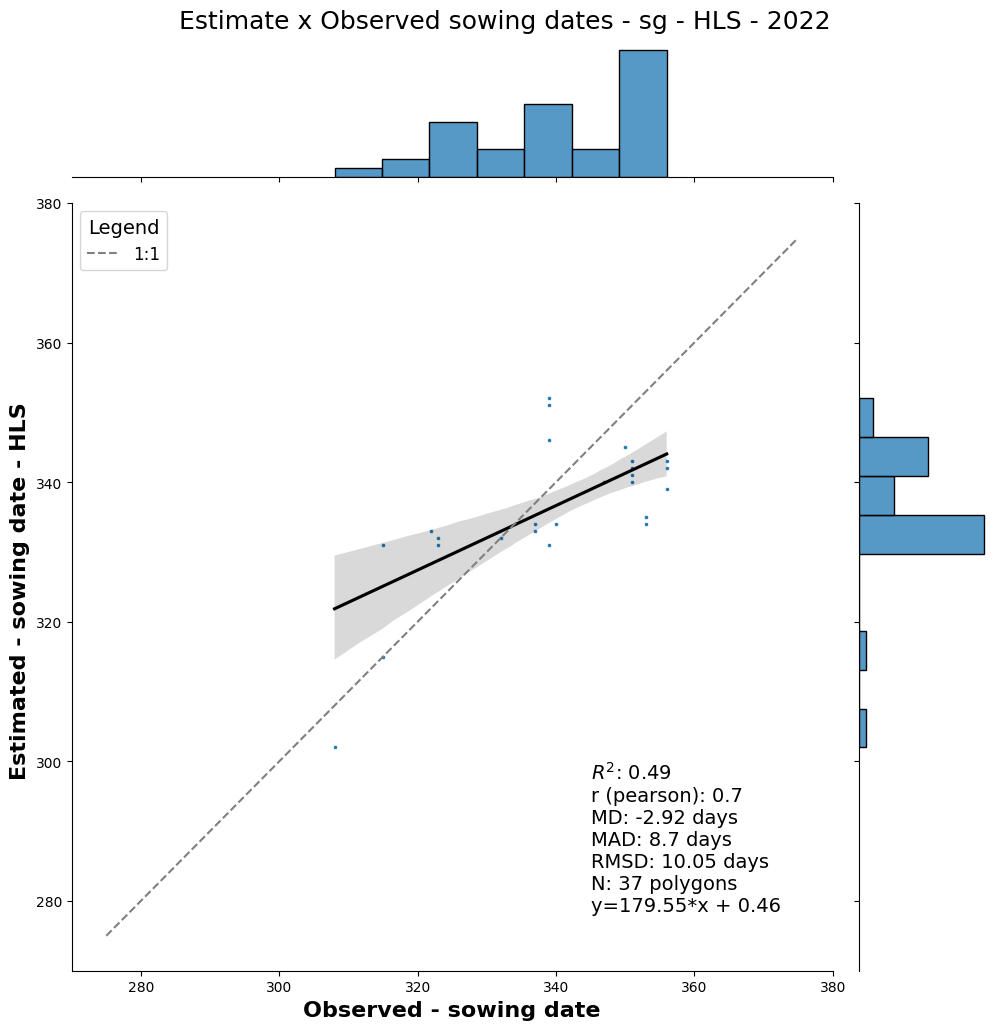

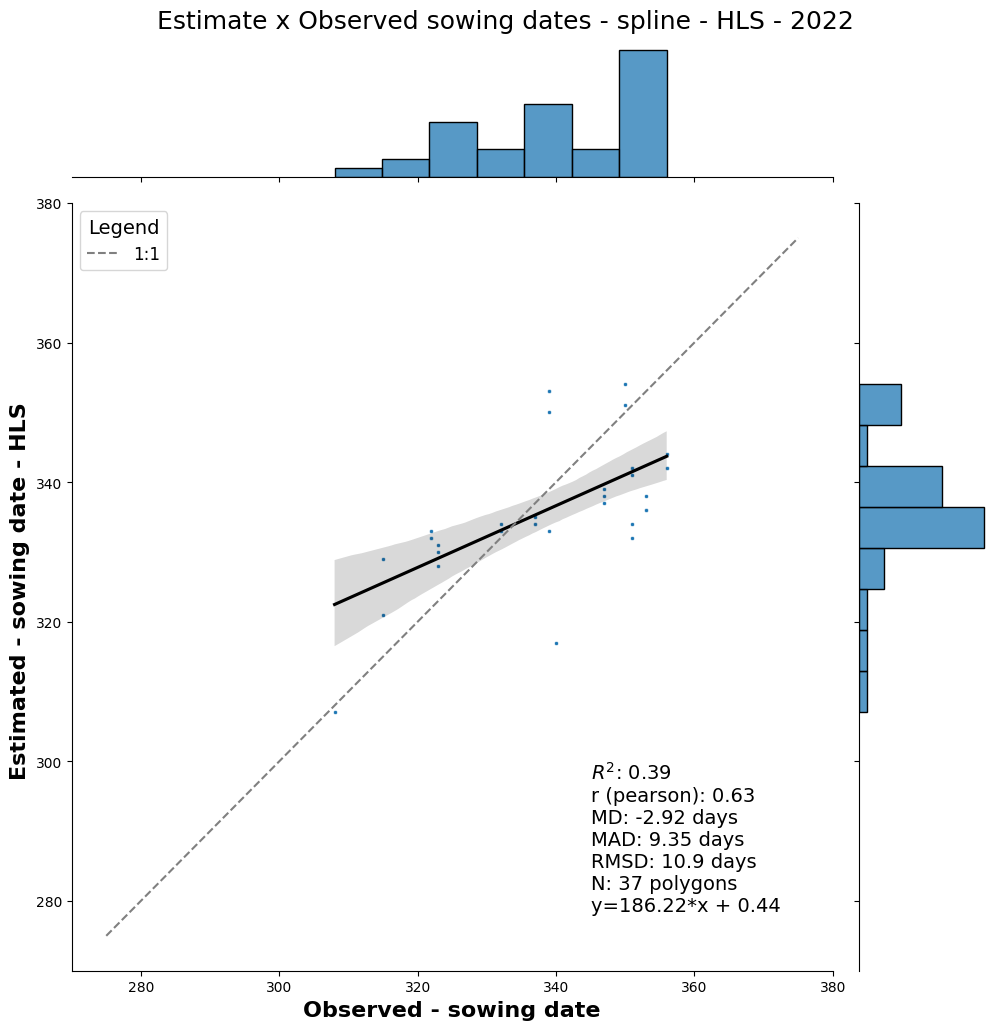

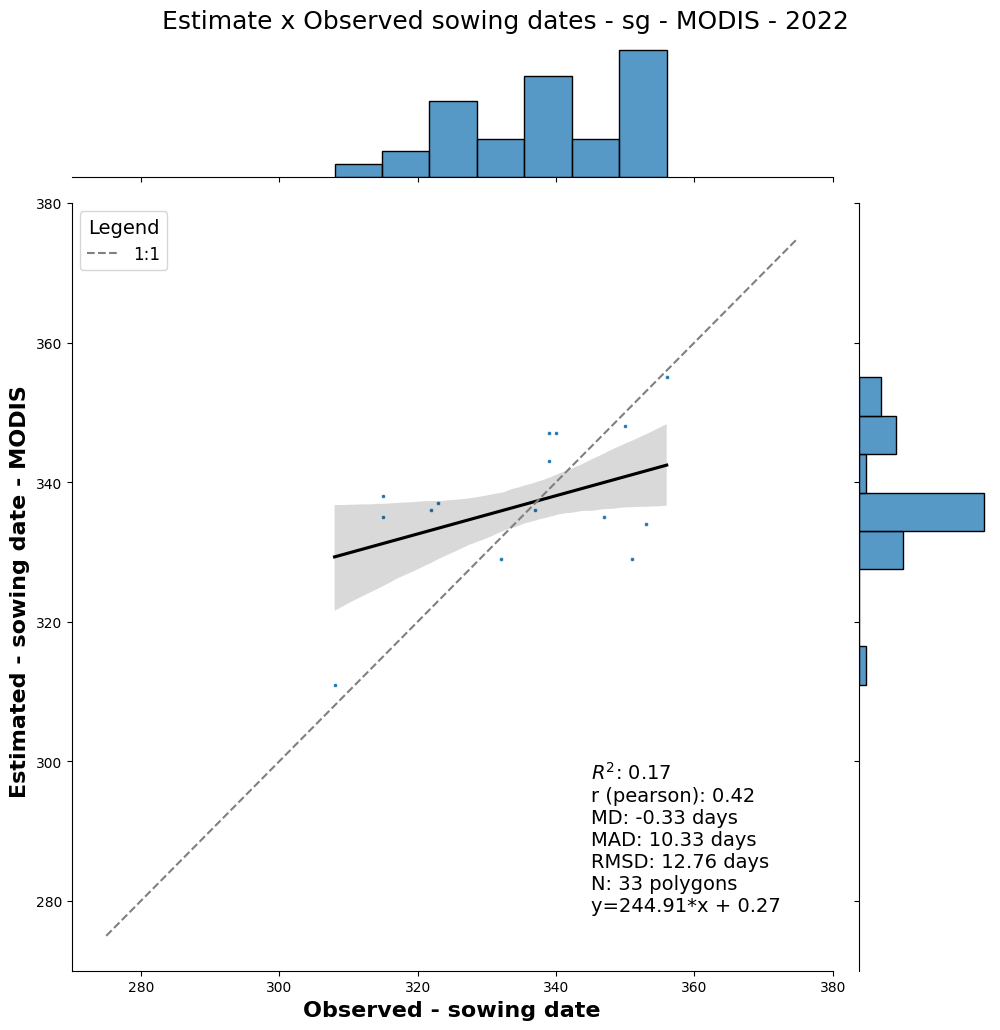

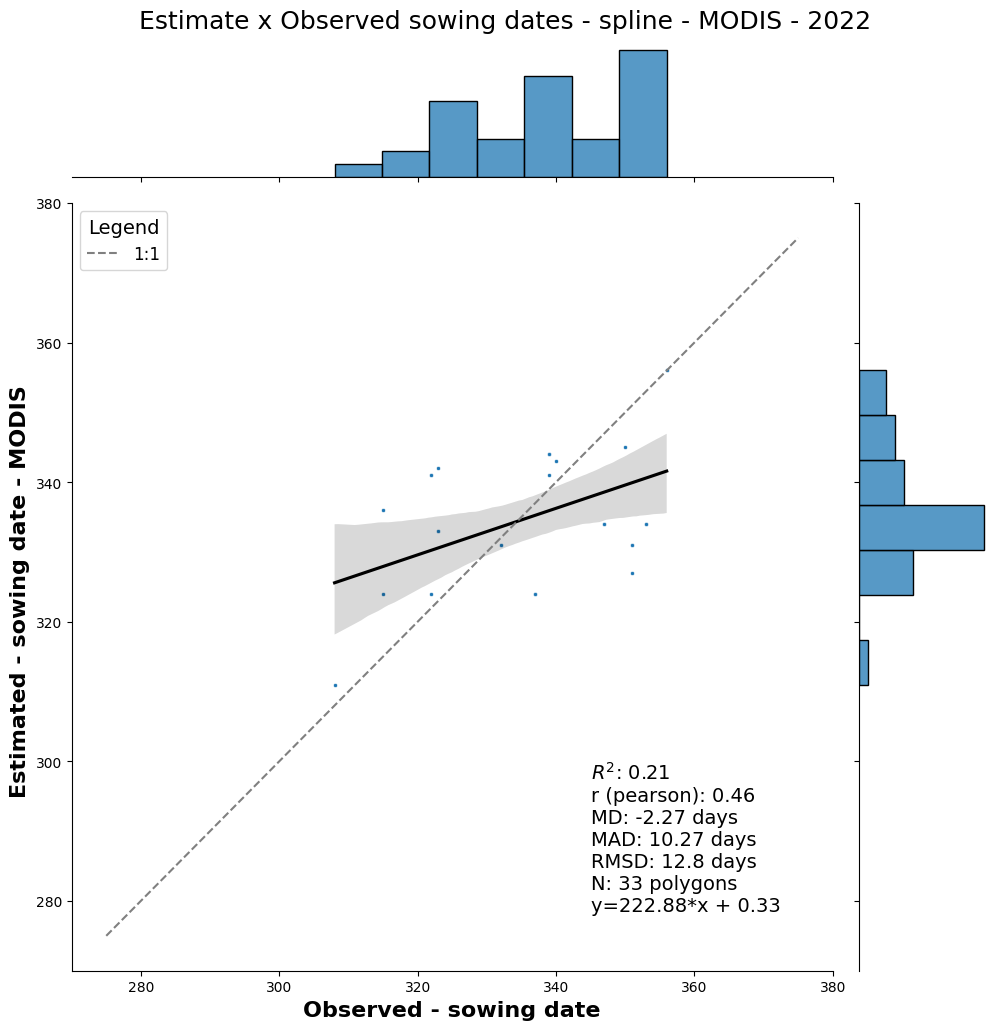

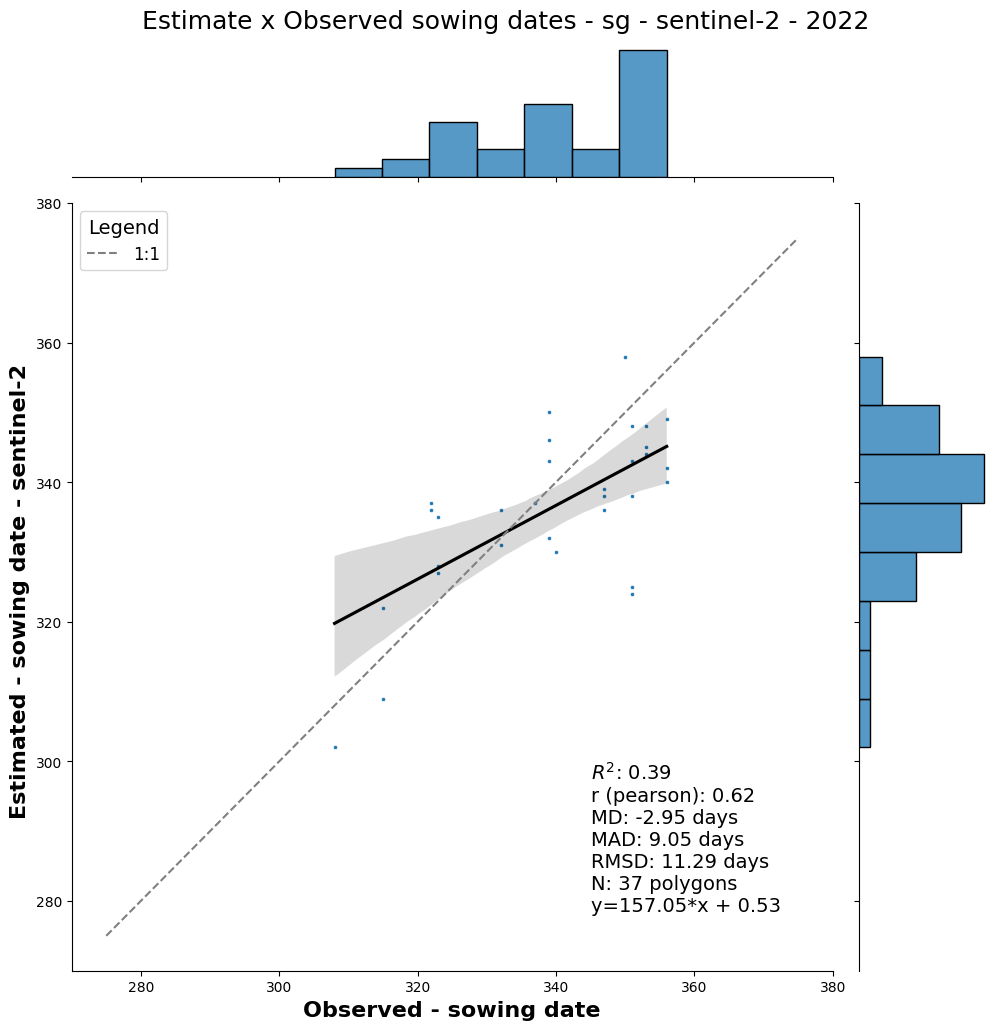

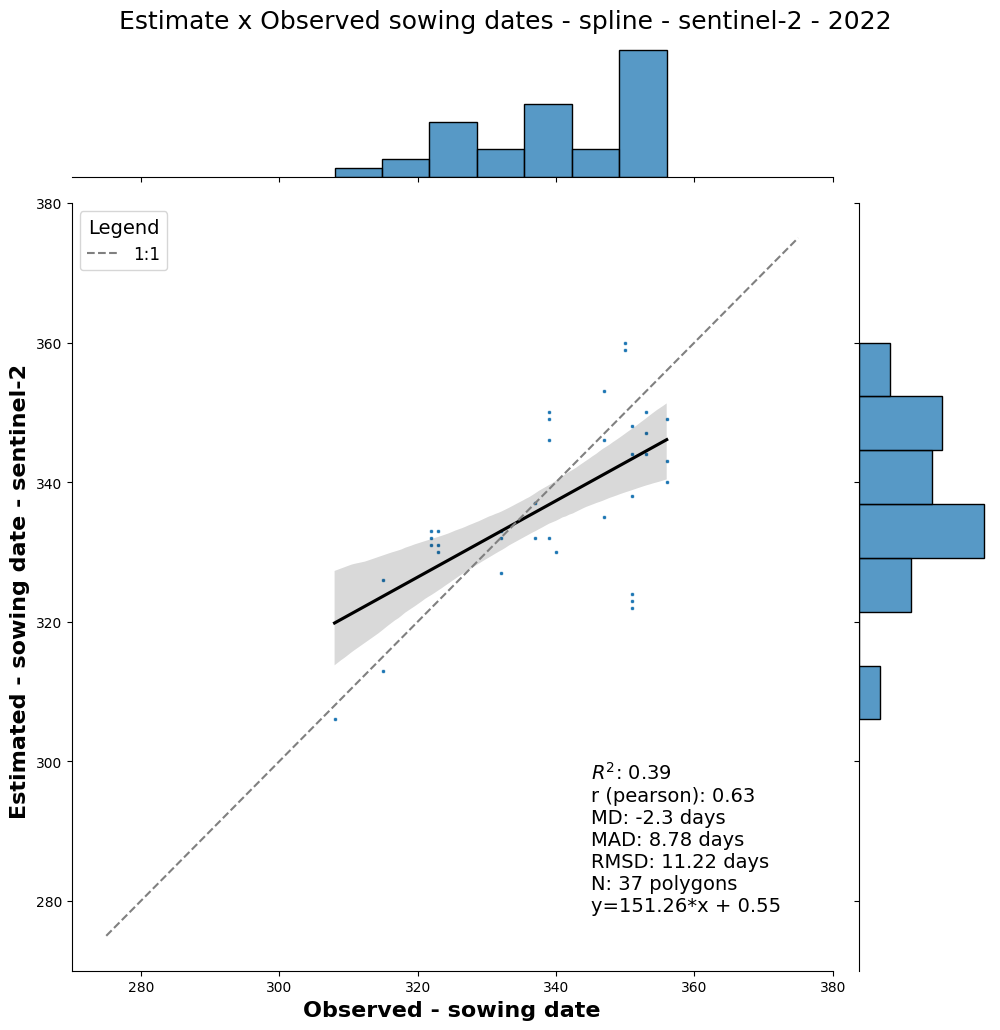

In [ ]:
# Iterate over each group
for group_name, group_df in grouped_df:
    # group_name is a tuple (sensor, smooth)
    # group_df is a DataFrame containing the data for that group
    df = group_df.copy()
    sensor = group_name[0]
    smooth = group_name[1]
    s = 20


    # Drop rows with NaN values in the specified columns
    # Note: If you want to drop rows with NaN in any of the columns,
    df =df.dropna(subset=[coly, colx], how='any')


    # Calculate the Pontius metrics using the mefuncs module
    # Note: mefuncs.pontius_equations returns a dictionary with the metrics
    pontius_results = mefuncs.pontius_equations (df=df, colx=colx, coly= coly)
    # Round all the numbers to 2 decimal places
    pontius_results = {key: round(value, 2) if isinstance(value, (int, float)) else value for key, value in pontius_results.items()}    

    a =  pontius_results['Intercept (a)']
    b =  pontius_results['Slope (b)']
    
    # Calculate the metrics using the mefuncs module. These are default metrics
    # Note: mefuncs.metrics_accuracy returns r2, mae, rmse
    r2, mae, rmse = mefuncs.metrics_accuracy(df= df,
                                    colx= colx,
                                    coly =coly,
                                    decimals=2)




    # Creating a new line for the results DataFrame
    # Note: pontius_results already contains the necessary metrics, so we can directly use them    
    new_line = {"sensor": sensor,
                "smooth": smooth,

                "R2": r2,
                "MAE": mae,
                "RMSE": rmse,
                "N": df.fkey.nunique(),
                'x_mean': pontius_results['Reference Mean (x̄)'],
                'y_mean':  pontius_results['Prediction Mean (ȳ)'],
                'md': pontius_results['Mean Deviation (MD)'],
                'mad':  pontius_results['Mean Absolute Deviation (MAD)'],
                'qd': pontius_results['Quantity Deviation (QD)'],
                'ad': pontius_results['Allocation Deviation (AD)'],
                'var_x': pontius_results['Variance in Reference (Var_x)'],
                'var_y': pontius_results['Variance in Prediction (Var_y)'],
                'r': pontius_results['Correlation (r)'],
                'r2':pontius_results['R-squared (r2)'],
                'b': a,
                'a': b,
                'eq': f'y={a}*x + {b}',
                'rmsd': pontius_results['Root Mean Square Deviation (RMSD)'],
                'dr': pontius_results['Willmott (dr)']
                }
    
    # Prepare the text to be displayed on the plot
    text =   f'''$R^2$: {new_line['r2']}
r (pearson): {new_line['r']}
MD: {new_line['md']} days
MAD: {new_line['mad']} days
RMSD: {new_line['rmsd']} days
N: {new_line["N"]} polygons
{new_line['eq']}
'''



    # Create a jointplot with a larger size
    joint = sns.jointplot(data=df, 
                        x=colx,
                        y=coly,

                        #   color="red",  # Color for scatter plot and marginal plots
                        marker=".", 
                        
                        height=10)
    
    # Fit a general regression line
    sns.regplot(data=df, x=colx, y=coly, scatter=False, ax=joint.ax_joint, color='black')
    # Calculate coefficients for the regression line
    slope, intercept = np.polyfit(df[colx], df[coly], 1)

    # Annotate the plot with the equation of the regression line
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    # Initialize y-coordinate for equation annotations
    y_pos = y_pos  # Start from top
    x_pos = x_pos
    joint.ax_joint.annotate(text, xy=(x_pos, y_pos), fontsize=14, ha='left', va='top', color="black")


        
    # Add the 1:1 line
    joint.ax_joint.plot(limitx, 
                        limity, 
                        color='gray', linestyle='--',
                        label="1:1")

    joint.ax_joint.legend(title='Legend', fontsize=12, title_fontsize='14', loc='upper left')
    # Set x and y axis labels
    joint.set_axis_labels(f"Observed - sowing date",f"Estimated - sowing date - {sensor} ", fontsize=16, fontweight='bold')
    # Add general title
    joint.fig.suptitle(f'Estimate x Observed sowing dates - {smooth} - {sensor} - 2022', fontsize=18, y=1.02)
    # plt.savefig(os.path.join(plot_output_dir, f"scatter_distribution_data_days_{smooth}_{sensor}.png"), bbox_inches='tight', dpi=300)
    plt.show()



    new_line_df = pd.DataFrame([new_line])

    results_sow_date = pd.concat([results_sow_date, new_line_df], ignore_index=True)


In [22]:
results_sow_date[results_sow_date["sensor"]=="sentinel-2"]

,sensor,smooth,R2,MAE,RMSE,N,x_mean,y_mean,md,mad,...,ad,var_x,var_y,r,r2,b,a,eq,rmsd,dr
4,sentinel-2,sg,0.39,11.29,9.05,37,339.19,336.24,-2.95,9.05,...,6.11,179.99,128.99,0.62,0.39,157.05,0.53,y=157.05*x + 0.53,11.29,0.60
5,sentinel-2,spline,0.39,11.22,8.78,37,339.19,336.89,-2.30,8.78,...,6.49,179.99,137.61,0.63,0.39,151.26,0.55,y=151.26*x + 0.55,11.22,0.61


In [23]:
results_sow_date

,sensor,smooth,R2,MAE,RMSE,N,x_mean,y_mean,md,mad,...,ad,var_x,var_y,r,r2,b,a,eq,rmsd,dr
0,HLS,sg,0.49,10.05,8.70,37,339.19,336.27,-2.92,8.70,...,5.78,179.99,78.85,0.70,0.49,179.55,0.46,y=179.55*x + 0.46,10.05,0.61
1,HLS,spline,0.39,10.90,9.35,37,339.19,336.27,-2.92,9.35,...,6.43,179.99,89.44,0.63,0.39,186.22,0.44,y=186.22*x + 0.44,10.90,0.59
2,MODIS,sg,0.17,12.76,10.33,33,337.79,337.45,-0.33,10.33,...,10.00,183.62,79.76,0.42,0.17,244.91,0.27,y=244.91*x + 0.27,12.76,0.54
3,MODIS,spline,0.21,12.80,10.27,33,337.79,335.52,-2.27,10.27,...,8.00,183.62,97.52,0.46,0.21,222.88,0.33,y=222.88*x + 0.33,12.80,0.55
4,sentinel-2,sg,0.39,11.29,9.05,37,339.19,336.24,-2.95,9.05,...,6.11,179.99,128.99,0.62,0.39,157.05,0.53,y=157.05*x + 0.53,11.29,0.60
5,sentinel-2,spline,0.39,11.22,8.78,37,339.19,336.89,-2.30,8.78,...,6.49,179.99,137.61,0.63,0.39,151.26,0.55,y=151.26*x + 0.55,11.22,0.61
